In [1]:
from dataclasses import dataclass, field
import numpy as np
import numpy.typing as npt
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq
from scipy.constants import pi, c, h
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.signal import correlate
from scipy.optimize import curve_fit

rcParams['figure.dpi'] = 300
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 3




LIGHTSPEED_M_PER_S = c
PLANCKCONST_J_PER_HZ = h






def get_freq_range_from_time(time_s: npt.NDArray[float]
                             ) -> npt.NDArray[float]:
    """
    Calculate frequency range for spectrum based on time basis.

    When plotting a discretized pulse signal as a function of time,
    a time range is needed. To plot the spectrum of the pulse, one
    can compute the FFT and plot it versus the frequency range
    calculated by this function

    Parameters
    ----------
    time_s : npt.NDArray[float]
        Time range in seconds.

    Returns
    -------
    npt.NDArray[float]
        Frequency range in Hz.

    """
    return fftshift(fftfreq(len(time_s), d=time_s[1] - time_s[0]))


def get_time_from_freq_range(frequency_Hz: npt.NDArray[float]
                             ) -> npt.NDArray[float]:
    """
    Calculate time range for pulse based on frequency range.

    Essentially the inverse of the get_freq_range_from_time function.
    If we have a frequency range and take the iFFT of a spectrum field
    to get the pulse field in the time domain, this function provides the
    appropriate time range.

    Parameters
    ----------
    frequency_Hz : npt.NDArray[float]
        Freq. range in Hz.

    Returns
    -------
    time_s : npt.NDArray[float]
        Time range in s.

    """

    time_s = fftshift(fftfreq(len(frequency_Hz),
                              d=frequency_Hz[1] - frequency_Hz[0]))
    return time_s


def get_spectrum_from_pulse(time_s: npt.NDArray[float],
                            pulse_field: npt.NDArray[complex],
                            FFT_tol: float = 1e-3) -> npt.NDArray[complex]:
    """

    Parameters
    ----------
    time_s : npt.NDArray[float]
        Time range in seconds.
    pulse_field: npt.NDArray[complex]
        Complex field of pulse in time domain in units of sqrt(W).
    FFT_tol : float, optional
        When computing the FFT and going from temporal to spectral domain, the
        energy (which theoretically should be conserved) cannot change
        fractionally by more than FFT_tol. The default is 1e-7.

    Returns
    -------
    spectrum_field : npt.NDArray[complex]
        Complex spectral field in units of sqrt(J/Hz).

    """

    pulseEnergy = get_energy(time_s, pulse_field)  # Get pulse energy
    f = get_freq_range_from_time(time_s)
    dt = time_s[1] - time_s[0]

    assert dt > 0, (f"ERROR: dt must be positive, "
                    f"but {dt=}. {time_s[1]=},{time_s[0]=}")
    spectrum_field = ifftshift(
        ifft(ifftshift(pulse_field))) * (dt*len(f))  # Do shift and take fft
    spectrumEnergy = get_energy(f, spectrum_field)  # Get spectrum energy

    err = np.abs((pulseEnergy / spectrumEnergy - 1))


    assert (
        err < FFT_tol
    ), (f"ERROR = {err:.3e} > {FFT_tol:.3e} = FFT_tol : Energy changed "
        "when going from Pulse to Spectrum!!!")

    return spectrum_field


def get_pulse_from_spectrum(frequency_Hz: npt.NDArray[float],
                            spectrum_field: npt.NDArray[complex],
                            FFT_tol: float = 1e-3) -> npt.NDArray[complex]:
    """
    Converts the spectral field of a signal in the freq. domain temporal
    field in time domain

    Uses the iFFT to shift from freq. to time domain and ensures that energy
    is conserved

    Parameters
    ----------
    frequency_Hz : npt.NDArray[float]
        Frequency in Hz.
    spectrum_field : npt.NDArray[complex]
        Spectral field in sqrt(J/Hz).
    FFT_tol : float, optional
        Maximum fractional change in signal
        energy when doing FFT. The default is 1e-7.

    Returns
    -------
    pulse : npt.NDArray[complex]
        Temporal field in sqrt(W).

    """

    spectrumEnergy = get_energy(frequency_Hz, spectrum_field)

    time = get_time_from_freq_range(frequency_Hz)
    dt = time[1] - time[0]

    pulse = fftshift(fft(fftshift(spectrum_field))) / (dt*len(time))
    pulseEnergy = get_energy(time, pulse)

    err = np.abs((pulseEnergy / spectrumEnergy - 1))



    assert (
        err < FFT_tol
    ), (f"ERROR = {err:.3e} > {FFT_tol:.3e} = FFT_tol : Energy changed too "
        "much when going from Spectrum to Pulse!!!")
    return pulse


def get_energy(
    time_or_freq: npt.NDArray[float],
    field_in_time_or_freq_domain: npt.NDArray[complex],
) -> float:
    """
    Computes energy of signal or spectrum

    Gets the power or PSD of the signal from
    get_power(field_in_time_or_freq_domain)
    and integrates it w.r.t. either time or
    frequency to get the energy.

    Parameters
    ----------
    time_or_freq : npt.NDArray[float]
        Time range in seconds or freq. range in Hz.
    field_in_time_or_freq_domain : npt.NDArray[complex]
        Temporal field in [sqrt(W)] or spectral field [sqrt(J/Hz)].

    Returns
    -------
    energy: float
        Signal energy in J .

    """
    energy = np.trapz(
        get_power(field_in_time_or_freq_domain), time_or_freq)
    return energy

def get_power(field_in_time_or_freq_domain: npt.NDArray[complex]
              ) -> npt.NDArray[float]:
    """
    Computes temporal power or PSD

    For a real electric field, power averaged over an optical cycle is

    P = 1/T int_0^T( E_real**2 )dt.

    For a complex electric field, this same power is calculated as

    P = 0.5*|E|**2.

    Using the complex field makes calculations easier and the factor of
    0.5 is simply absorbed into the nonlinear parameter, gamma.
    Same thing works in the frequency domain.

    Parameters
    ----------
    field_in_time_or_freq_domain : npt.NDArray[complex]
        Temporal or spectral field.

    Returns
    -------
    power : npt.NDArray[complex]
        Temporal power (W) or PSD (J/Hz) at any instance or frequency.

    """
    power = np.abs(field_in_time_or_freq_domain) ** 2
    return power

def get_average(time_or_freq: npt.NDArray[float],
                pulse_or_spectrum: npt.NDArray[complex]) -> float:
    """
    Computes central time (or frequency) of pulse (spectrum)

    Computes central time (or frequency) of pulse (spectrum) by calculating
    the 'expectation value'.

    Parameters
    ----------
    time_or_freq : npt.NDArray[float]
        Time range in seconds or freq. range in Hz.
    pulse_or_spectrum : npt.NDArray[complex]
        Temporal or spectral field.

    Returns
    -------
    meanValue : float
        average time or frequency.

    """

    E = get_energy(time_or_freq, pulse_or_spectrum)
    meanValue = np.trapz(
        time_or_freq * get_power(pulse_or_spectrum), time_or_freq) / E
    return meanValue


def get_variance(time_or_freq: npt.NDArray[float],
                 pulse_or_spectrum: npt.NDArray[complex]) -> float:
    """
    Computes variance of pulse or spectrum

    Computes variance of pulse in time domain or freq domain via
    <x**2>-<x>**2

    Parameters
    ----------
    time_or_freq : npt.NDArray[float]
        Time range in seconds or freq. range in Hz.
    pulse_or_spectrum : npt.NDArray[complex]
        Temporal or spectral field.

    Returns
    -------
    variance : float
        variance in time or frequency domains.

    """
    E = get_energy(time_or_freq, pulse_or_spectrum)
    variance = (
        np.trapz(time_or_freq ** 2 *
                 get_power(pulse_or_spectrum), time_or_freq) / E
        - (get_average(time_or_freq, pulse_or_spectrum)) ** 2
    )
    return variance


def get_stdev(time_or_freq: npt.NDArray[float],
              pulse_or_spectrum: npt.NDArray[complex]) -> float:
    """
    Computes standard deviation of pulse or spectrum

    Computes std of pulse in time domain or freq domain via
    sqrt(<x**2>-<x>**2)

    Parameters
    ----------
    time_or_freq : npt.NDArray[float]
        Time range in seconds or freq. range in Hz.
    pulse_or_spectrum : npt.NDArray[complex]
        Temporal or spectral field.

    Returns
    -------
    stdev : float
        Stdev in time or frequency domains.

    """

    stdev = np.sqrt(get_variance(time_or_freq, pulse_or_spectrum))
    return stdev

def get_phase(pulse: npt.NDArray[complex]) -> npt.NDArray[float]:
    """
    Gets the phase of the pulse from its complex angle

    Calcualte phase by getting the complex angle of the pulse,
    unwrapping it and centering on middle entry.

    Parameters
    ----------
    pulse : npt.NDArray[complex]
        Complex electric field envelope in time domain.

    Returns
    -------
    phi : npt.NDArray[float]
        Phase of pulse at every instance in radians.

    """

    phi = np.unwrap(np.angle(pulse))  # Get phase starting from 1st entry
    phi = phi - phi[int(len(phi) / 2)]  # Center phase on middle entry
    return phi

def wavelength_to_freq(wavelength_m: float) -> float:
    """
    Converts wavelength in m to frequency in Hz

    Converts wavelength in m to frequency in Hz using f=c/lambda

    Parameters:
        wavelength_m (float): Wavelength in m

    Returns:
        float: Frequency in Hz
    """
    return LIGHTSPEED_M_PER_S / wavelength_m



0.010000000000049032 0.9999900000914931


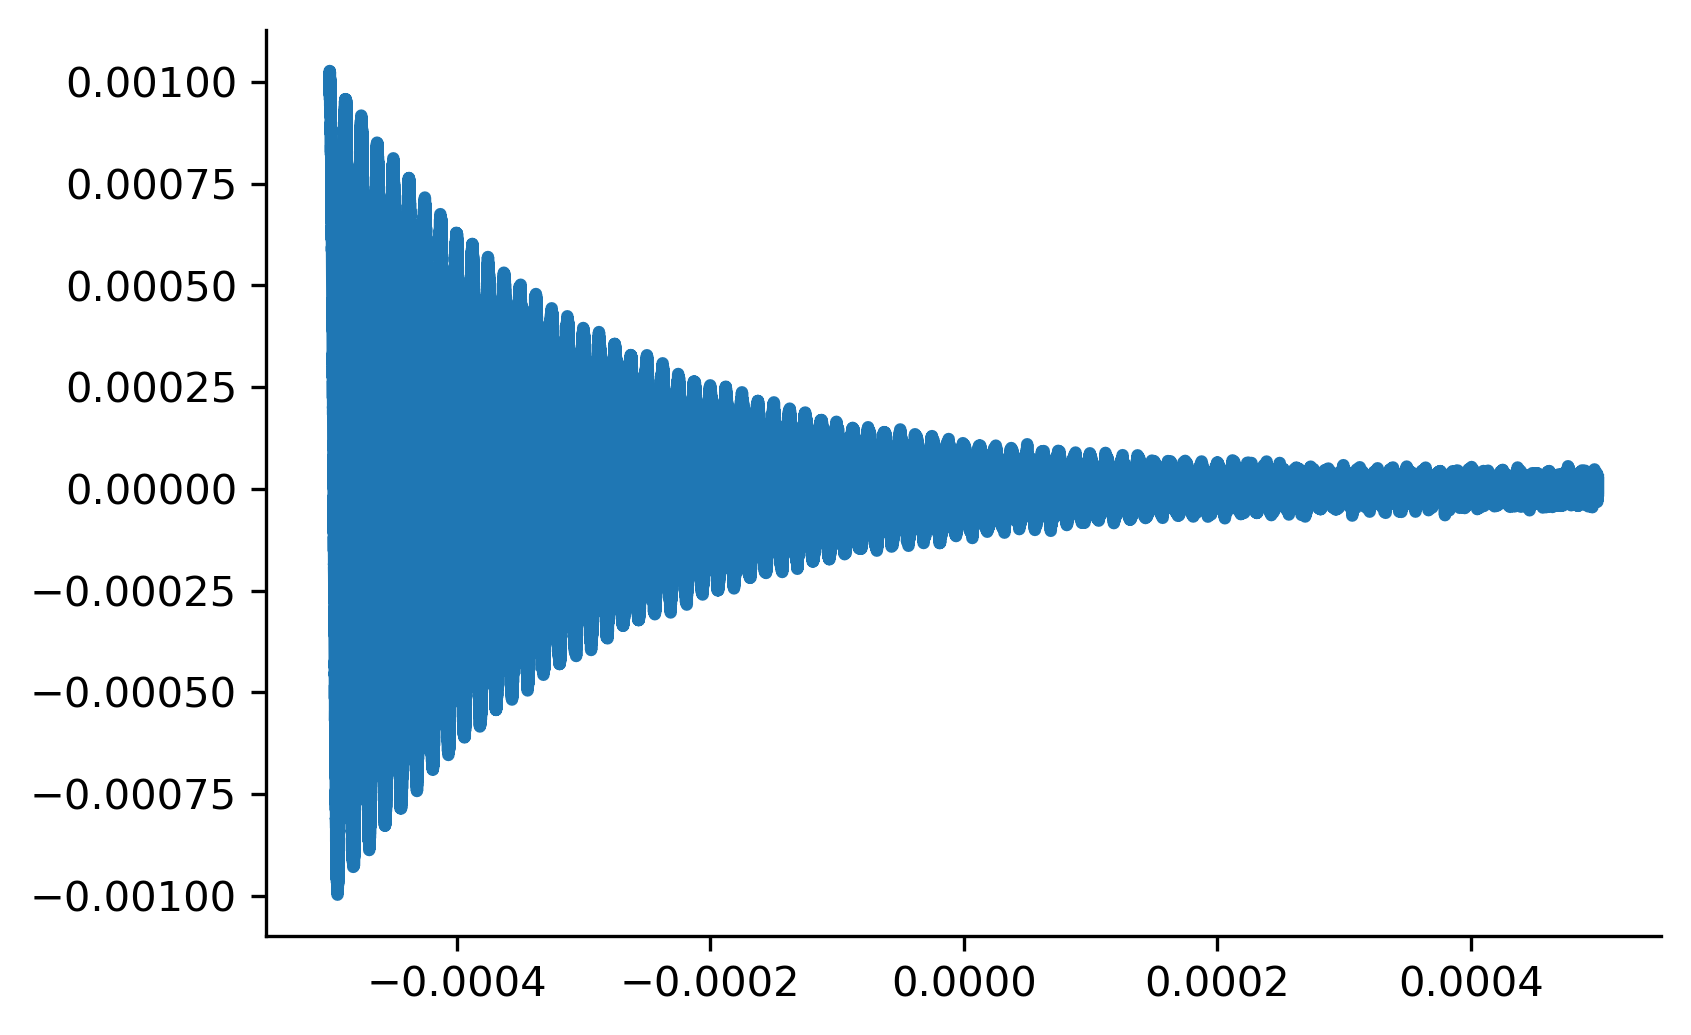

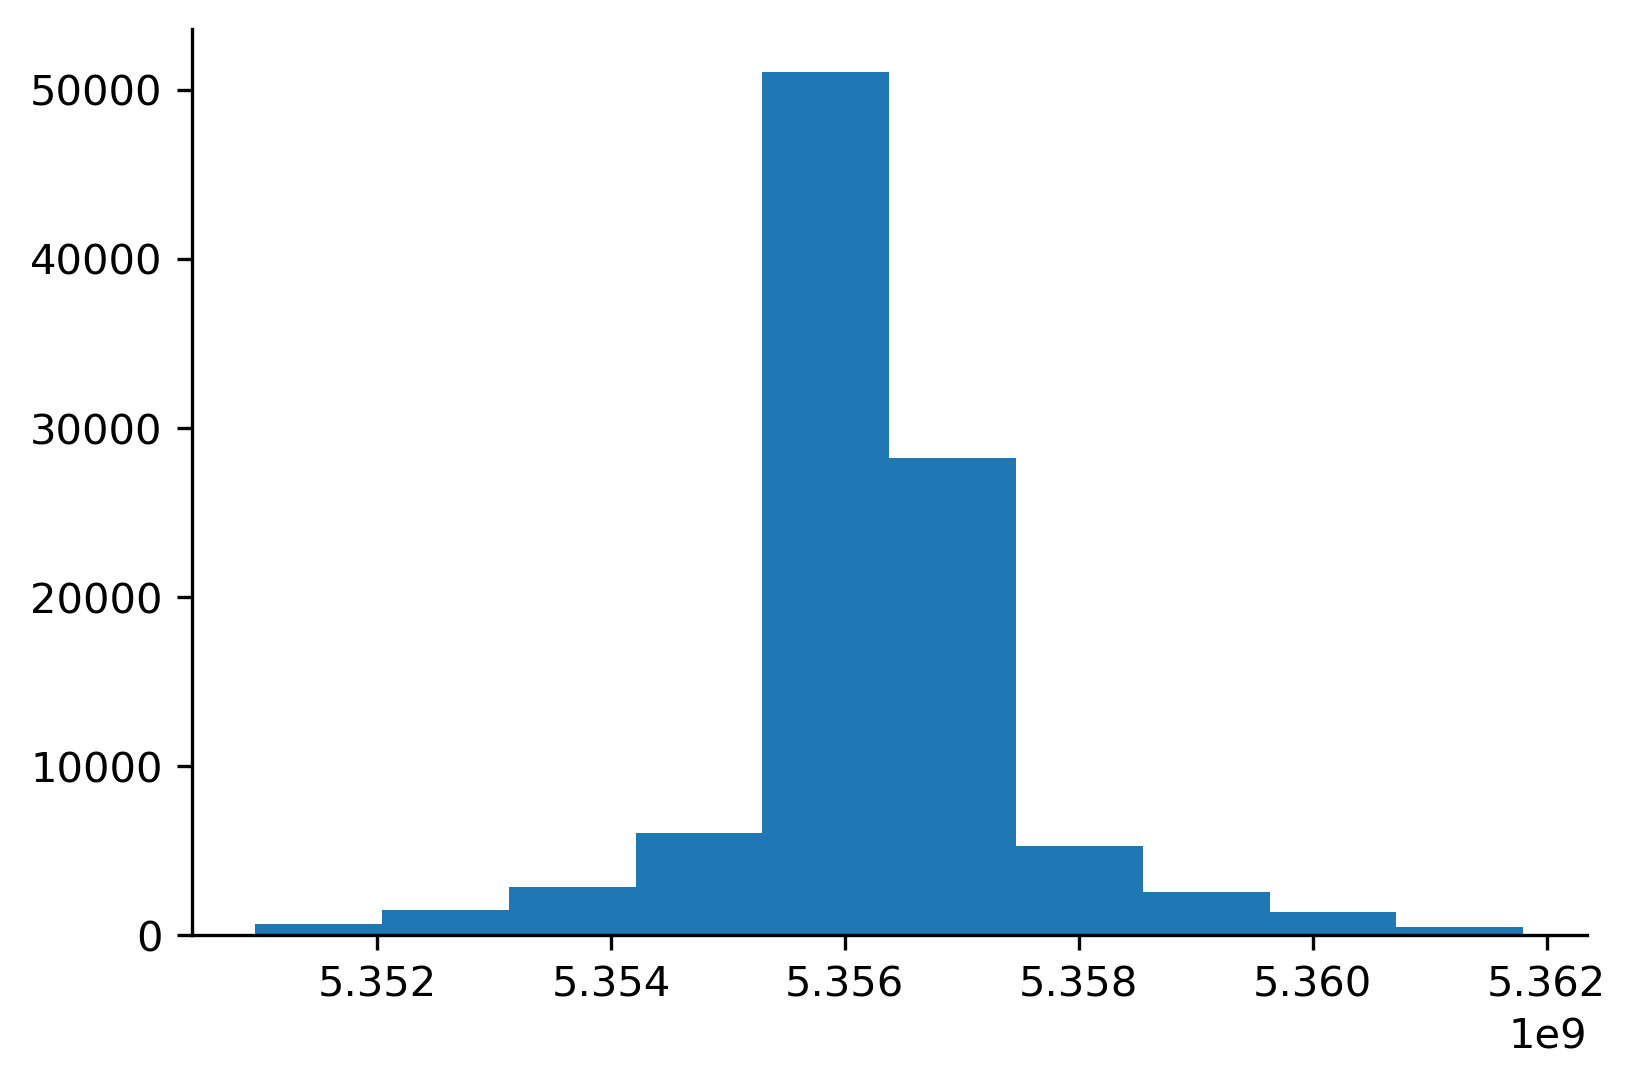

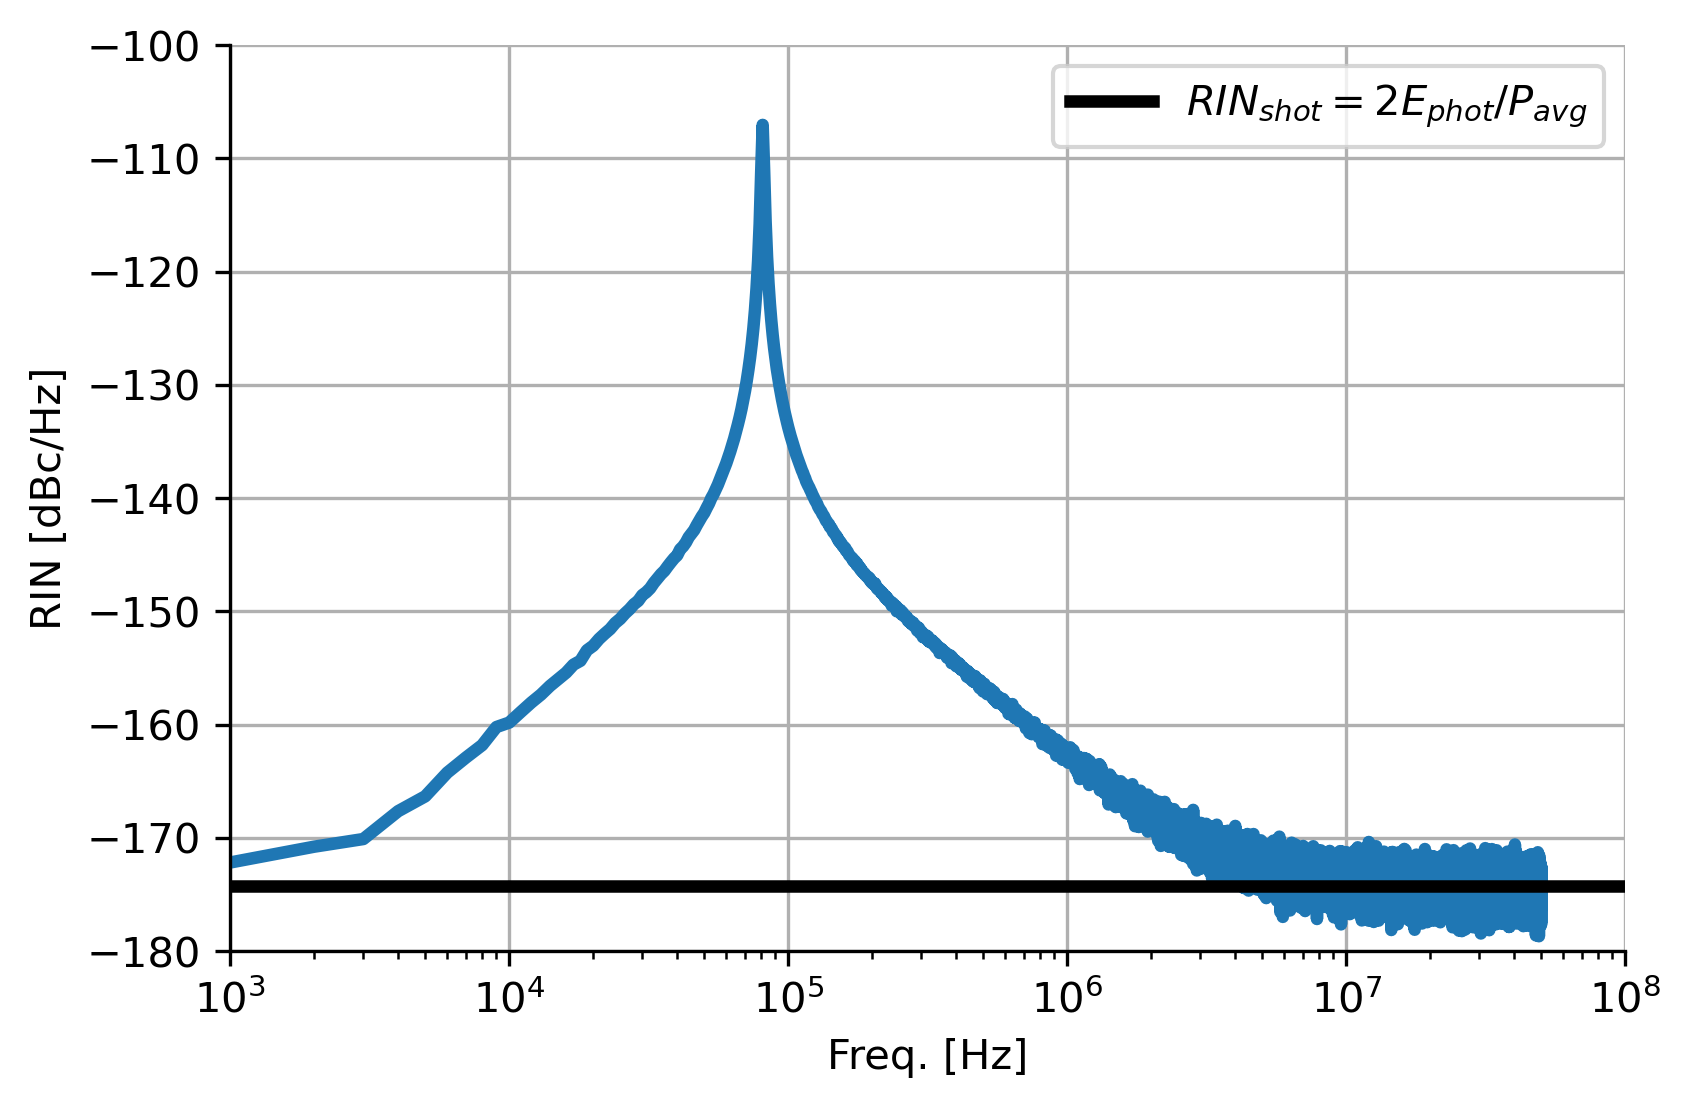

In [3]:
N=1e5+1
t=np.linspace(-0.5e-3,0.5e-3,int(N))
dt = t[1]-t[0]
f = get_freq_range_from_time(t)
df = f[1]-f[0]

print(dt*1e6,df/1e3)

P_avg=0.1 #W


P_osc = P_avg/1000
f_osc = 80e3 #Laser relaxation oscillation frequency
t_damp = 200e-6 #Dampening time in s

laser_freq_Hz = wavelength_to_freq(1064e-9)
E_phot = PLANCKCONST_J_PER_HZ*laser_freq_Hz
N_phot_avg = P_avg/E_phot*dt
#Generate several random walks 
np.random.seed(123)
N_samples = 20
average_RIN_spectrum = np.zeros_like(t)*1.0


for idx in range(N_samples):
    rng = np.random.default_rng()
    
    s = rng.poisson(lam=N_phot_avg+P_osc/E_phot*dt*np.exp(-np.abs(t-t[0])/t_damp)*np.cos(2*np.pi*f_osc*t), size=len(t))
    
    P_time = (E_phot/dt*s)    #P_osc*np.exp(-np.abs(t-t[0])/t_damp)*np.cos(2*np.pi*f_osc*t) + 
    r_n = P_time/P_avg-1
    
    average_RIN_spectrum += get_power(get_spectrum_from_pulse(t,r_n,FFT_tol=1e-2))*df




    
    
average_RIN_spectrum/=N_samples

fig,ax=plt.subplots()
ax.plot(t,r_n)
plt.show()

fig,ax=plt.subplots()
ax.hist(s)
plt.show()

fig,ax=plt.subplots()
ax.plot(f[len(f)//2:-1],10*np.log10(2*average_RIN_spectrum[len(f)//2:-1]))
ax.set_xscale('log')
ax.set_xlabel('Freq. [Hz]')
ax.set_ylabel('RIN [dBc/Hz]')
ax.set_xlim(1e3,100e6)
ax.set_ylim(-180,-100)
ax.axhline(y=10*np.log10(2*E_phot/P_avg),color='k',label='$RIN_{shot}=2E_{phot}/P_{avg}$')
ax.grid()
ax.legend()
plt.show()




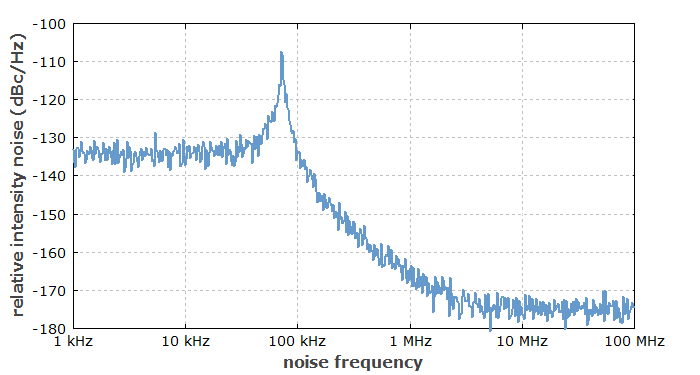